# Predicting Human Toll of Tornado Events

## Capstone 1: Springboard Data Science Track

## The Problem:
Of all the forces mother nature can bring to bear on mankind, one of the most violent and unpredictable is the tornado. Meteorologists and Climatologists can spend their entire careers studying these destructive storms in an effort to improve warning lead-time and lessen the likelihood of loss of life. NOAA (the National Oceanic and Atmospheric Administration) has diligently collected data on all of the tornadoes impacting the United States in the last ~70 years, but can this basic data tell us anything about whether a given tornado, (defined by things like width, location, and duration) is likely to cause injuries or deaths? This is the question we'll seek to answer, and we'll do so by feeding our preprocessed tornado data into a series of predictive Machine Learning models.

First, we'll import all of the python libraries needed to power our models and compare their effectiveness.

In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve, roc_auc_score

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

Then we'll load and inspect the final dataset that we cleaned and analyzed in previous steps.

In [36]:
df = pd.read_csv('D:/Springboard/Second_Capstone/raw_data/Preprocessed_Data.csv')
df.head()
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25193 entries, 0 to 25192
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              25193 non-null  int64  
 1   inj                     25193 non-null  int64  
 2   fat                     25193 non-null  int64  
 3   yr                      25193 non-null  int64  
 4   mo                      25193 non-null  int64  
 5   mag                     25193 non-null  int64  
 6   len                     25193 non-null  float64
 7   wid                     25193 non-null  int64  
 8   no_counties             25193 non-null  int64  
 9   track_pop               25193 non-null  float64
 10  track_area              25193 non-null  float64
 11  track_pop_den           25135 non-null  float64
 12  USD_prop_dam            25193 non-null  int64  
 13  hour                    25193 non-null  int64  
 14  start_lat               25193 non-null

In [37]:
df['deaths'].value_counts()
df['harm'].value_counts()

0.0    21017
1.0     4176
Name: harm, dtype: int64

In [38]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('deaths', axis=1, inplace=True)
df.drop('inj', axis=1, inplace=True)
df.drop('fat', axis=1, inplace=True)
df.drop('wet_or_dry_yr_Dry', axis=1, inplace=True)
df.drop('wet_or_dry_yr_Normal', axis=1, inplace=True)
df.drop('wet_or_dry_yr_Wet', axis=1, inplace=True)
df.drop('precip_class_Dry', axis=1, inplace=True)
df.drop('precip_class_Wet', axis=1, inplace=True)
df.drop('precip_class_Normal', axis=1, inplace=True)
df.drop('warm_or_cool_yr_Normal', axis=1, inplace=True)
df.drop('temp_class_Cool', axis=1, inplace=True)
df.drop('temp_class_Normal', axis=1, inplace=True)
df.drop('temp_class_Warm', axis=1, inplace=True)

df.head()

,yr,mo,mag,len,wid,no_counties,track_pop,track_area,track_pop_den,USD_prop_dam,hour,start_lat,start_lon,harm
0,1951,1,3,16.8,317,2,159129.416,2026.64,99.9,500000,17,31.30,-92.47,1.0
1,1952,1,2,0.5,400,1,91016.814,1037.82,87.7,500000,19,41.60,-80.30,0.0
2,1953,1,2,4.5,100,1,8683.180,598.84,14.5,5000,20,33.83,-92.17,1.0
3,1956,1,3,23.0,150,2,193736.975,1706.48,174.8,50000,21,35.20,-92.45,1.0
4,1957,1,1,2.5,10,1,3374879.166,2126.98,1586.7,50000,13,21.52,-158.07,0.0


In [39]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [40]:
clean_dataset(df)

,yr,mo,mag,len,wid,no_counties,track_pop,track_area,track_pop_den,USD_prop_dam,hour,start_lat,start_lon,harm
0,1951.0,1.0,3.0,16.80,317.0,2.0,159129.416,2026.64,99.9,500000.0,17.0,31.3000,-92.4700,1.0
1,1952.0,1.0,2.0,0.50,400.0,1.0,91016.814,1037.82,87.7,500000.0,19.0,41.6000,-80.3000,0.0
2,1953.0,1.0,2.0,4.50,100.0,1.0,8683.180,598.84,14.5,5000.0,20.0,33.8300,-92.1700,1.0
3,1956.0,1.0,3.0,23.00,150.0,2.0,193736.975,1706.48,174.8,50000.0,21.0,35.2000,-92.4500,1.0
4,1957.0,1.0,1.0,2.50,10.0,1.0,3374879.166,2126.98,1586.7,50000.0,13.0,21.5200,-158.0700,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25188,2019.0,12.0,1.0,4.79,100.0,1.0,48427.632,1407.78,34.4,50000000.0,17.0,34.5798,-103.3425,0.0
25189,2019.0,12.0,1.0,1.20,160.0,2.0,698048.006,1178.06,1058.1,50000000.0,15.0,36.0121,-95.7647,0.0
25190,2019.0,12.0,1.0,6.60,500.0,1.0,19608.190,737.15,26.6,50000000.0,15.0,33.0978,-89.5429,0.0
25191,2019.0,12.0,1.0,7.70,900.0,1.0,19608.190,737.15,26.6,50000000.0,16.0,33.1628,-89.4323,0.0


In [41]:
df = df[[c for c in df if c not in ['harm']] + ['harm']]

In [42]:
#df.drop(['index'])
df.head()

,yr,mo,mag,len,wid,no_counties,track_pop,track_area,track_pop_den,USD_prop_dam,hour,start_lat,start_lon,harm
0,1951,1,3,16.8,317,2,159129.416,2026.64,99.9,500000,17,31.30,-92.47,1.0
1,1952,1,2,0.5,400,1,91016.814,1037.82,87.7,500000,19,41.60,-80.30,0.0
2,1953,1,2,4.5,100,1,8683.180,598.84,14.5,5000,20,33.83,-92.17,1.0
3,1956,1,3,23.0,150,2,193736.975,1706.48,174.8,50000,21,35.20,-92.45,1.0
4,1957,1,1,2.5,10,1,3374879.166,2126.98,1586.7,50000,13,21.52,-158.07,0.0


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25135 entries, 0 to 25192
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   yr             25135 non-null  int64  
 1   mo             25135 non-null  int64  
 2   mag            25135 non-null  int64  
 3   len            25135 non-null  float64
 4   wid            25135 non-null  int64  
 5   no_counties    25135 non-null  int64  
 6   track_pop      25135 non-null  float64
 7   track_area     25135 non-null  float64
 8   track_pop_den  25135 non-null  float64
 9   USD_prop_dam   25135 non-null  int64  
 10  hour           25135 non-null  int64  
 11  start_lat      25135 non-null  float64
 12  start_lon      25135 non-null  float64
 13  harm           25135 non-null  float64
dtypes: float64(7), int64(7)
memory usage: 2.9 MB


Predictor variables and their explanations:
- yr: The year in which the tornado occurred.
- mo: The month in which the tornado occurred.  
- mag: The magnitude of the tornado on the EF-scale. This ranges from 1-5, with 5 being the largest and most destructive.
- len: The length of the tornado's on-ground track, measured in linear miles.
- wid: The width of the tornado funnel, measured in linear yards.
- no_counties: The number of counties through which the tornado traveled.  
- track_pop: The total population for all counties in the tornado's track.
- track_area: The total land-area for all counties in the tornado's track.
- track_pop_den: The combined population density for all of the counties in the tornado's track.
- USD_prop_dam: The rough US-dollar value of property damage caused by the tornado. This measure is tiered.  
- hour: The hour of day in which the tornado first touched down. 
- start_lat: The latitude coordinate (in degrees) for the tornado's origination point.
- start_lon: The longitude coordinate (in degrees) for the tornado's origination point.

And finally, we have our variable to be predicted:
- harm: An "either/or" combination of Injuries and Deaths. If a tornado caused either or both, it has a harm value of 1, otherwise its value is 0.

Next we must separate our predictor variables from our target variable, split the remaining data into our 'train' and 'test' datasets, and do some scaling to ensure that variable magnitude doesn't skew our results.

In [80]:
X = df.drop(['harm'], axis=1)
y = df['harm']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [45]:
scaler = StandardScaler()

In [46]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform (X_test)

## Model Deployment
The problem we are modeling is a classification problem with labels, so we will deploy and compare the results for the following supervised learning models:

- Logistic Regression
- Decision Tree
- K-Nearest Neighbor (KNN)
- Support vector machine (SVM)
- Random Forest
- Gradient Boost

Each of these model types have additional parameters that must be set (known as hyperparameters), and optimal values are not always intuitive. As such we will deploy Random Search CV to optimally tune these parameters. Research has shown that Random Search performs nearly as well as the more robust GridSearchCV while being far less resource-hungry. Since we have several different models to evaluate, we view this as a worthwhile tradeoff.

Also, a note on how we will compare the models in terms of performance:
The dataset we are using, with "harm" as the predicted variable, is very unbalanced. This means that the number of cases where harm occurred is only a small percentage of the overall number of tornado events (~17% to be precise). That means that a model designed to only choose "no harm" would be "correct" 83% of the time. As such, model accuracy, the most straightforward measure, is not an attractive option in this case. 

Instead we'll be using two other measures: **f1-score** and **Area under the ROC curve**.
The f1-score is a weighted average of *precision* and *recall*, where precision is the ratio of True Positives to all positive predictions (TP+FP), and recall is the ratio of True Positives to the sum of True Positives and False Negatives. Recall is also known as sensitivity. f1-scores are useful in that they attempt to strike a balance between minimizing False Positives (in this case predicting harm when none occurred) and minimizing False Negatives (predicting no harm when harm occurred).

The ROC curve is a plot of the True Positive Rate on the y-axis, and the False Positive Rate on the x-axis. Intuitively, this means a "perfect" model that never misclassifies will be a rectangle with points at (0,1) and (1,0). The area under this idealized curve is 1.0, or 100%. As such, we can use the area under our actual ROC curves to evaluate the effectiveness of our models, with AUC (area under curve) values indicating better performance as they increase toward 1.0.

## Logistic Regression

Not much hyperparameter tuning is required, but two parameters are likely worth testing:

- Penalty, which refers to the <i>type</i> of penalty levied on models for using too many parameters. (‘none’, ‘l1’, ‘l2’, ‘elasticnet’)
- C, which represents the <i>strength</i> of penalty that gets applied. (100, 10, 1.0, 0.1, 0.01)

We will tune these parameters using RandomSearchCV with 5 fold cross-validation (default).

In [47]:
# Tuning penalty and C using RandomSearchCV

model = LogisticRegression()

penalty = ['none', 'l1', 'l2', 'elasticnet']
c_values = [100, 10, 1.0, 0.1, 0.01]
LR_params = dict(penalty=penalty,C=c_values)

rand_search = RandomizedSearchCV(model, LR_params, n_iter=100, scoring='f1', n_jobs=-1, random_state=42)

rand_result = rand_search.fit(X_train, y_train)
print(rand_result.best_params_)
print(rand_result.best_score_)


{'penalty': 'l2', 'C': 1.0}
0.38145064970453396


In [48]:
# Fitting the Logistic Regression model to the training data using the optimal parameters found in the previous step
LogReg = LogisticRegression(penalty = 'none', C = 100, random_state = 42)
LogReg.fit(X_train,y_train)

# Using model to predict on the test set
y_pred_LR = LogReg.predict(X_test)

In [49]:
conf_matrix = confusion_matrix(y_test,y_pred_LR)
print(conf_matrix)

LogReg_acc = accuracy_score(y_test, y_pred_LR)
LogReg_f1=f1_score(y_test,y_pred_LR)
LogReg_roc_auc = roc_auc_score(y_test, y_pred_LR)

print('The accuracy score for Logistic Regression is '+ str(round(LogReg_acc, 4)))
print('The f1 score for Logistic Regression is ' + str(round(LogReg_f1, 4)))
print('The score for area under the ROC for Logistic Regression is ' + str(round(LogReg_roc_auc, 4)))

[[4058  113]
 [ 619  237]]
The accuracy score for Logistic Regression is 0.8544
The f1 score for Logistic Regression is 0.393
The score for area under the ROC for Logistic Regression is 0.6249


## Decision Tree

The two hyperparameters that we want to tune for our Decision Tree model are:

- criterion, which refers to the measure used to choose one branch of the tree over another. Either entropy or gini.
- max_depth, which limits the number of layers that the decision tree is allowed to create. Used to prevent overfitting.

As before, we will tune these parameters using RandomSearchCV with 5 fold cross-validation (default).

In [50]:
# Decision Tree
model = DecisionTreeClassifier()

criterion = ['gini', 'entropy']
max_depth = np.linspace(1, 32, 32, endpoint=True)

DT_params = dict(criterion=criterion,max_depth=max_depth)

rand_search = RandomizedSearchCV(model, DT_params, n_iter=100, scoring='roc_auc', n_jobs=-1, random_state=42)

rand_result = rand_search.fit(X_train, y_train)
print(rand_result.best_params_)
print(rand_result.best_score_)

{'max_depth': 6.0, 'criterion': 'gini'}
0.8132926424004564


In [51]:
# Fitting the Decision Tree model to the training data using the optimal parameters found in the previous step
DecTree = DecisionTreeClassifier(criterion = 'gini', max_depth = 6, random_state = 42)
DecTree.fit(X_train,y_train)

# Using model to predict on the test set
y_pred_DT = DecTree.predict(X_test)

In [52]:
conf_matrix = confusion_matrix(y_test,y_pred_DT)
print(conf_matrix)

DecTree_acc = accuracy_score(y_test, y_pred_DT)
DecTree_f1=f1_score(y_test,y_pred_DT)
DecTree_roc_auc = roc_auc_score(y_test, y_pred_DT)

print('The accuracy score for Decision Tree is '+ str(round(DecTree_acc, 4)))
print('The f1 score for Decision Tree is ' + str(round(DecTree_f1, 4)))
print('The score for area under the ROC for Decision Tree is ' + str(round(DecTree_roc_auc, 4)))

[[4024  147]
 [ 579  277]]
The accuracy score for Decision Tree is 0.8556
The f1 score for Decision Tree is 0.4328
The score for area under the ROC for Decision Tree is 0.6442


## K-Nearest Neighbors

The two hyperparameters that we want to tune for our KNN model are:

- n_neighbors, which refers to the number of neighbors used to determine grouping behavior. We'll evaluate a range of 1-25.
- metric, which is the method by which distance is calculated, either manhattan or euclidean. 

Again, we will tune these parameters using RandomSearchCV with 5 fold cross-validation (default).

In [53]:
# K-Nearest-Neighbors
model = KNeighborsClassifier()

n_neighbors = list(range(1, 25))
metric = ['manhattan', 'euclidean']

KNN_params = dict(n_neighbors=n_neighbors,metric=metric)

rand_search = RandomizedSearchCV(model, KNN_params, n_iter=100, scoring='roc_auc', n_jobs=-1, random_state=42)

rand_result = rand_search.fit(X_train, y_train)
print(rand_result.best_params_)
print(rand_result.best_score_)

{'n_neighbors': 24, 'metric': 'manhattan'}
0.787553754507299


In [54]:
# Fitting the K-Nearest-Neighbors model to the training data using the optimal parameters found in the previous step
KNN = KNeighborsClassifier(n_neighbors = 24, metric='manhattan')
KNN.fit(X_train,y_train)

# Using model to predict on the test set
y_pred_KN = KNN.predict(X_test)

In [55]:
conf_matrix = confusion_matrix(y_test,y_pred_KN)
print(conf_matrix)

KNN_acc = accuracy_score(y_test, y_pred_KN)
KNN_f1=f1_score(y_test,y_pred_KN)
KNN_roc_auc = roc_auc_score(y_test, y_pred_KN)

print('The accuracy score for K-Nearest-Neighbors is '+ str(round(KNN_acc, 4)))
print('The f1 score for K-Nearest-Neighbors is ' + str(round(KNN_f1, 4)))
print('The score for area under the ROC for K-Nearest-Neighbors is ' + str(round(KNN_roc_auc, 4)))

[[4088   83]
 [ 658  198]]
The accuracy score for K-Nearest-Neighbors is 0.8526
The f1 score for K-Nearest-Neighbors is 0.3483
The score for area under the ROC for K-Nearest-Neighbors is 0.6057


## Support Vector Machines

The two hyperparameters that we want to tune for our Decision Tree model are:

- kernel, which refers to the feature space that will be used to create the decision boundaries. (linear, poly, rbf, sigmoid)
- C, which represents the strength of penalty that gets applied for misclassified data points. (100, 10, 1.0, 0.1, 0.01)

We will tune these parameters using RandomSearchCV with 5 fold cross-validation (default).

In [56]:
# Support Vector Machines
model = SVC()

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [100, 10, 1.0, 0.1, 0.001]

SVM_params = dict(kernel=kernel, C=C)

rand_search = RandomizedSearchCV(model, SVM_params, n_iter=100, scoring='roc_auc', n_jobs=-1, random_state=42)

rand_result = rand_search.fit(X_train, y_train)
print(rand_result.best_params_)
print(rand_result.best_score_)

{'kernel': 'linear', 'C': 0.1}
0.7837161612163961


In [57]:
# Fitting the Support Vector Machines SVC model to the training data using the optimal parameters found in the previous step
SVM = SVC(kernel = 'linear', C = 0.1)
SVM.fit(X_train,y_train)

# Using model to predict on the test set
y_pred_SVM = SVM.predict(X_test)

In [58]:
conf_matrix = confusion_matrix(y_test,y_pred_SVM)
print(conf_matrix)

SVM_acc = accuracy_score(y_test, y_pred_SVM)
SVM_f1=f1_score(y_test,y_pred_SVM)
SVM_roc_auc = roc_auc_score(y_test, y_pred_SVM)

print('The accuracy score for Support Vector Machines SVC is '+ str(round(SVM_acc, 4)))
print('The f1 score for Support Vector Machines SVC is ' + str(round(SVM_f1, 4)))
print('The score for area under the ROC for Support Vector Machines SVC is ' + str(round(SVM_roc_auc, 4)))

[[4159   12]
 [ 800   56]]
The accuracy score for Support Vector Machines SVC is 0.8385
The f1 score for Support Vector Machines SVC is 0.1212
The score for area under the ROC for Support Vector Machines SVC is 0.5313


## Random Forest

The three hyperparameters that we want to tune for our Random Forest model are:

- max_features, which refers to the max number of features assigned to specific tree in the random forest. Range of 1-20. 
- max_depth, which limits the number of layers a particular tree can have in the random forest. Range of 2-9.
- n_estimators, which represents the number of trees to be considered. (10, 100, 1000)

We will tune these parameters using RandomSearchCV with 5 fold cross-validation (default).

In [59]:
# Random Forest
model = RandomForestClassifier()

max_features = list(range(1, 20))
max_depth = list(range(2, 9))
n_estimators = [10, 100, 1000]

RF_params = dict(max_features=max_features, n_estimators=n_estimators, max_depth=max_depth)

rand_search = RandomizedSearchCV(model, RF_params, n_iter=50, scoring='roc_auc', n_jobs=-1, random_state=42)

rand_result = rand_search.fit(X_train, y_train)
print(rand_result.best_params_)
print(rand_result.best_score_)

{'n_estimators': 100, 'max_features': 3, 'max_depth': 8}
0.8324504324508151


In [64]:
# Fitting the Random Forest model to the training data using the optimal parameters found in the previous step
RF = RandomForestClassifier(max_features = 3, n_estimators = 100, max_depth=8)
RF.fit(X_train,y_train)

# Using model to predict on the test set
y_pred_RF = RF.predict(X_test)

In [65]:
conf_matrix = confusion_matrix(y_test,y_pred_RF)
print(conf_matrix)

RF_acc = accuracy_score(y_test, y_pred_RF)
RF_f1=f1_score(y_test,y_pred_RF)
RF_roc_auc = roc_auc_score(y_test, y_pred_RF)

print('The accuracy score for Random Forest is '+ str(round(RF_acc, 4)))
print('The f1 score for Random Forest is ' + str(round(RF_f1, 4)))
print('The score for area under the ROC for Random Forest is ' + str(round(RF_roc_auc, 4)))

[[4077   94]
 [ 613  243]]
The accuracy score for Random Forest is 0.8594
The f1 score for Random Forest is 0.4074
The score for area under the ROC for Random Forest is 0.6307


## Gradient Boosting

The four hyperparameters that we want to tune for our Gradient Boosting model are:

- learning_rate, which determines the impact of each tree on the final outcome. (0.001, 0.01, 0.1)
- subsample, which represents the fraction of observations to be selected for each tree. (0.5, 0.7, 1.0)
- n_estimators, which represents the number of trees to be considered. (10, 100, 1000)
- max_depth, which limits the number of layers a particular tree can have in the random forest. (3, 7, or 9)

We will tune these parameters using RandomSearchCV with 5 fold cross-validation (default).

In [66]:
# Gradient Boosting
model = GradientBoostingClassifier()

learning_rate = [0.001, 0.01, 0.1]
n_estimators = [10, 100, 1000]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]

GB_params = dict(max_features=max_features, n_estimators=n_estimators)

rand_search = RandomizedSearchCV(model, GB_params, n_iter=50, scoring='roc_auc', n_jobs=-1, random_state=42)

rand_result = rand_search.fit(X_train, y_train)
print(rand_result.best_params_)
print(rand_result.best_score_)

{'n_estimators': 100, 'max_features': 13}
0.8331818385897153


In [67]:
# Fitting the Gradient Boosting model to the training data using the optimal parameters found in the previous step
GB = GradientBoostingClassifier(n_estimators=100, max_features=13)
GB.fit(X_train,y_train)

# Using model to predict on the test set
y_pred_GB = GB.predict(X_test)

In [68]:
conf_matrix = confusion_matrix(y_test,y_pred_GB)
print(conf_matrix)

GB_acc = accuracy_score(y_test, y_pred_GB)
GB_f1=f1_score(y_test,y_pred_GB)
GB_roc_auc = roc_auc_score(y_test, y_pred_GB)

print('The accuracy score for Gradient Boosting is '+ str(round(LogReg_acc, 4)))
print('The f1 score for Gradient Boosting is ' + str(round(GB_f1, 4)))
print('The score for area under the ROC for Gradient Boosting is ' + str(round(GB_roc_auc, 4)))

[[4032  139]
 [ 556  300]]
The accuracy score for Gradient Boosting is 0.8544
The f1 score for Gradient Boosting is 0.4633
The score for area under the ROC for Gradient Boosting is 0.6586


## Model Comparison

In [69]:
model_Labels = ['Logistic Regression','Decision Tree', 'KNN','SVM', 'Random Forest', 'Gradient Boost']
f1_scores= [LogReg_f1, DecTree_f1, KNN_f1, SVM_f1, RF_f1, GB_f1]
ROC_Area = [LogReg_roc_auc, DecTree_roc_auc, KNN_roc_auc, SVM_roc_auc, RF_roc_auc, GB_roc_auc]

score_tab = pd.DataFrame(list(zip(model_Labels, f1_scores, ROC_Area)), 
               columns =['Algorithm', 'f1 Score', 'ROC-AUC score' ]) 

score_tab

,Algorithm,f1 Score,ROC-AUC score
0,Logistic Regression,0.393035,0.624889
1,Decision Tree,0.432812,0.644177
2,KNN,0.348285,0.605705
3,SVM,0.121212,0.531272
4,Random Forest,0.407376,0.630671
5,Gradient Boost,0.463320,0.658571


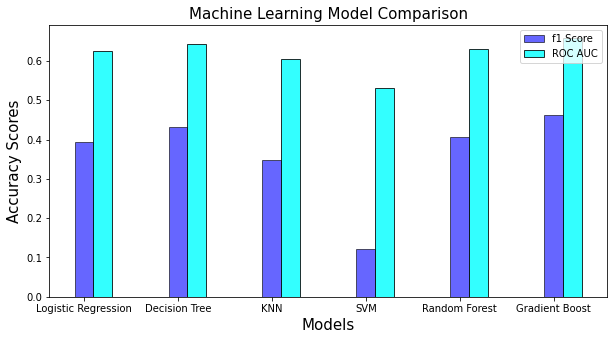

In [78]:
#plotting and comparing ROC-AUC train/test scores:

index=[1,2,3,4,5,6]
index_acc=[1.2,2.2,3.2,4.2,5.2,6.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Accuracy Scores',fontsize=15)
plt.title('Machine Learning Model Comparison',fontsize=15)
_=plt.bar(index,f1_scores,color='b',alpha=0.6,label='f1 Score',edgecolor='k',width=0.2)
_=plt.bar(index_acc, ROC_Area,color='cyan',alpha=0.8,label='ROC AUC',edgecolor='k',width=0.2)
plt.xticks([1,2,3,4,5,6], model_Labels)
plt.legend()
plt.show()

With an f1 score of 0.4633, and an area under the ROC of 0.6586, our Gradient Boosting model is the most accurate.

We will now take a more focused look at this model and its results in order to determine which features were the most predictive, among other insights.

## Feature Importances

         Features  Importance scores
0              yr           0.002837
1              mo           0.004411
2             mag           0.005986
3             len           0.009100
4             wid           0.010861
5     no_counties           0.022192
6       track_pop           0.028491
7      track_area           0.049473
8   track_pop_den           0.053607
9    USD_prop_dam           0.055809
10           hour           0.086148
11      start_lat           0.120753
12      start_lon           0.550331


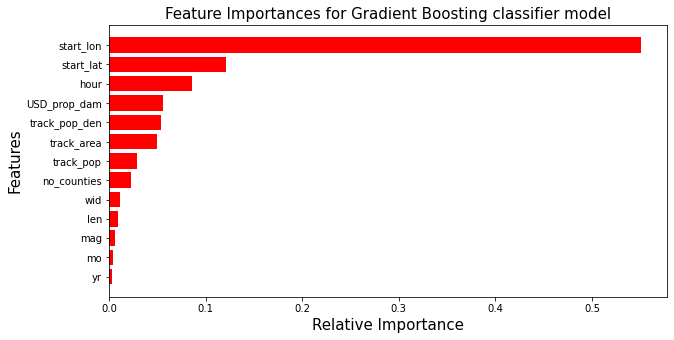

In [74]:
#Feature importances:

features = X
importances = list(GB.feature_importances_)
imp=np.sort(importances)
tab=pd.DataFrame(list(zip(X,imp)),columns =['Features', 'Importance scores']) 
print(tab)

#Visual comparison:
plt.figure(figsize=(10,5))
index = [0,1,2,3,4,5,6,7,8,9,10,11,12]
_=plt.barh(index,imp, align='center',color='r')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.yticks(index, features)
plt.title('Feature Importances for Gradient Boosting classifier model',fontsize=15)
plt.show()

In [76]:
y_scores_GB = GB.predict_proba(X_test)
y_scores_GB = y_scores_GB[:,1]
auroc = roc_auc_score(y_test, y_scores_GB)
print("ROC-AUC Score:", auroc)

ROC-AUC Score: 0.8368001017259807


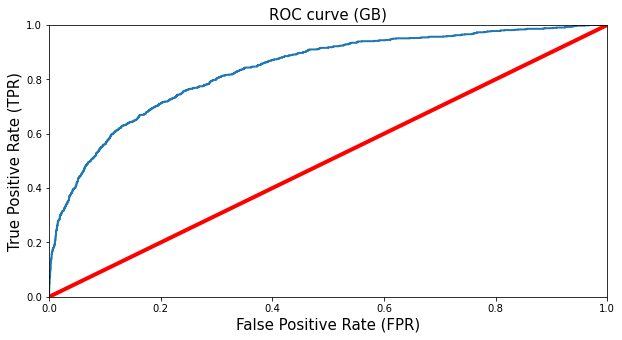

In [77]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_scores_GB)
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title('ROC curve (Gradient Boosting)',fontsize=15)

plt.figure(figsize=(10, 5))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

## Results Interpretation
According to the feature importances chart, starting longitude is the most predictive feature by a significant margin. This is perhaps a bit of an unexpected result, but when you consider the way population density tends to increase as you move from the Great Plains toward the East Coast, it begins to seem like a more meaningful outcome. Starting latitude is the second most significant feature, and again, if you think in terms of population density as you move South toward the Gulf Coast, it doesn't feel unreasonable.

Next are hour and USD Property Damage. Both of these make sense, as tornadoes that strike in the middle of the night and tornadoes that cause higher levels of structural damage are both intuitively more likely to cause injuries and deaths.

Perhaps surprising is the fact that tornado width, track length, and magnitude are fairly close to the bottom of the list of feature importances. But, when you consider that even a comparitively "weak" or "small" tornado still has more than enough power to destroy homes and other buildings, this begins to make sense as well.

## Conclusion and Next Steps

Given the massive number of variables outside our scope of consideration that can go into determining loss of life in a tornado event, we feel positively about the results we achieved with our models, especially the Gradient Boosting model that achieved the highest f1-score and area under the ROC. 

We know, however, that there is still room for improvement. In the end, aside from county population density data, we only pressed forward with predictor variables present in the base dataset. As such, there are other variables to consider whose addition could yield an even more robust model.

Some possibilities include:
- Historical climate data by county: We attemped to include climate data to classify the month and year a tornado occurred in as wet/normal/dry and warm/normal/cool relative to historical climate data for its origination county, but in the end, we were unable to properly scale these values in a way that prevented them from being over-weighted in the models. This is an area where a few tweaks could potentially yield significant results.
- Home Age data by county: We were able to find data that reasonably approximated this measure, but again, it didn't prove to be workable in its current form. Still, it would be interesting to see if improvements in building technology have resulted in any decrease in human toll caused by tornadoes.
- Long-term weather patterns (e.g. El Niño/La Niña): Do years under a certain weather pattern result in more or deadlier tornadoes?
- Prevalence of basements in homes: This might be a tricky measure to find, but homes closer to sea level tend to be built without basements, which removes one of the most effective sheltering options in the event of a tornado strike.

